In [1]:
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [2]:
import pandas as pd
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from imblearn.under_sampling import RandomUnderSampler
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

In [4]:
## Load the autoreload extension
%load_ext autoreload 
%autoreload 2

import custom_functions as fn

In [6]:
# Load Data from your path
df = pd.read_csv("Data/yelp-reviews-CA-2015-2018.csv.gz", index_col = 'date', parse_dates=['date'])
## Remove any non-english reivews
df = df.loc[df['language']=='en'].copy()
# Keep only 1,3,5 star reviews
df = df.loc[df['stars'].isin([1,3,5])]
# Take a smaller subset
df = df.loc['2018']
# Set the index
df = df.set_index('review_id')
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 31074 entries, VHNKGpE1xZkDbCdSVQEJsg to Fbzo2Z8CfH8naCbEPPhREw
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  31074 non-null  object
 1   text         31074 non-null  object
 2   stars        31074 non-null  int64 
 3   language     31074 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


,business_id,text,stars,language
review_id,,,,
VHNKGpE1xZkDbCdSVQEJsg,Ygjm8DI291yE05TrRwyXlg,"If you even think you or your child has been exposed to lice you have to make Noelle your first call! She's AMAZING! She squeezed us in on New Year's Eve and was thorough, efficient and so knowledgeable. She took the time to show me what she was ...",5,en
Ebl0LmHkLsQk9hP0rBm3GA,KSYONgGtrK0nKXfroB-bwg,"Ate here twice and had both atmosphere and great tapas. The Jamon plate, bravas, Spanish omelette, stuffed date, pork, Brussels sprouts, wine and amazing pear dessert...I could go on and on. If visiting, Please make a reservation as soon as you a...",5,en


In [7]:
# Let's take a look at the length of the each text
# We will split on each space, and then get the length
df['sequence_length'] =df['text'].map( lambda x: len(x.split(" ")))
df.head()

,business_id,text,stars,language,sequence_length
review_id,,,,,
VHNKGpE1xZkDbCdSVQEJsg,Ygjm8DI291yE05TrRwyXlg,"If you even think you or your child has been exposed to lice you have to make Noelle your first call! She's AMAZING! She squeezed us in on New Year's Eve and was thorough, efficient and so knowledgeable. She took the time to show me what she was ...",5,en,92
Ebl0LmHkLsQk9hP0rBm3GA,KSYONgGtrK0nKXfroB-bwg,"Ate here twice and had both atmosphere and great tapas. The Jamon plate, bravas, Spanish omelette, stuffed date, pork, Brussels sprouts, wine and amazing pear dessert...I could go on and on. If visiting, Please make a reservation as soon as you a...",5,en,67
bdbpnpm9JanC3gChaNFS-A,1nkpUITVPGKyeJbw0rJJ2w,Ringing in the New Year at one of my wife's good friends wedding in Santa Barbara this weekend and of course I pack the wrong pants and forgot an extra shirt for the weekend. Being a big and tall guy I can never just go to a regular store to grab...,5,en,125
DBa7PNBoBGJMc2qXXl4pRA,54oLdsGU9B8HxFTqCCqV-A,"My boyfriend and I got recommended this place by a SB local! We were just amazed! Everything from the look and feel of the place to the appetizer to the main dish, the dessert and the service was just perfect! Our food was just amazing!!!",5,en,45
BMfEah7vUKUvQeUTCR34iQ,omnCKxL0f_akh0eYeJxjDg,"I had no expectations being a first time customer, however it didn't live up to the expectations. It being a busy night I'm surprised they did not have enough bartenders at the bar. It also made it hard not knowing who was a bartender and on top ...",1,en,67


In [8]:
df['sequence_length'].describe()

count    31074.000000
mean        88.208502
std         83.728329
min          6.000000
25%         37.000000
50%         63.000000
75%        110.000000
max       1006.000000
Name: sequence_length, dtype: float64

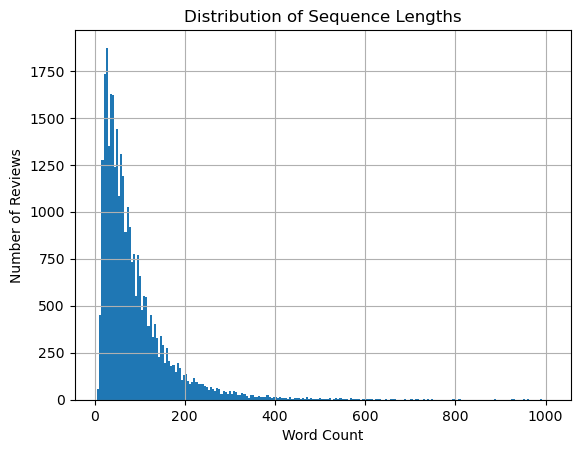

In [9]:
# Make histogram of sequence lengths
ax = df['sequence_length'].hist(bins = 'auto')
ax.set_xlabel('Word Count')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of Sequence Lengths');

In [10]:
# Define a filter to identify reviews less than 400 words
filter_short = df['sequence_length']< 400
print(f'Number of reviews >400 words is: {len(df) - filter_short.sum()}')

Number of reviews >400 words is: 359


In [11]:
# Keep short reviews (<400 words)
df=  df.loc[filter_short]
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 30715 entries, VHNKGpE1xZkDbCdSVQEJsg to Fbzo2Z8CfH8naCbEPPhREw
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_id      30715 non-null  object
 1   text             30715 non-null  object
 2   stars            30715 non-null  int64 
 3   language         30715 non-null  object
 4   sequence_length  30715 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.4+ MB


,business_id,text,stars,language,sequence_length
review_id,,,,,
VHNKGpE1xZkDbCdSVQEJsg,Ygjm8DI291yE05TrRwyXlg,"If you even think you or your child has been exposed to lice you have to make Noelle your first call! She's AMAZING! She squeezed us in on New Year's Eve and was thorough, efficient and so knowledgeable. She took the time to show me what she was ...",5,en,92
Ebl0LmHkLsQk9hP0rBm3GA,KSYONgGtrK0nKXfroB-bwg,"Ate here twice and had both atmosphere and great tapas. The Jamon plate, bravas, Spanish omelette, stuffed date, pork, Brussels sprouts, wine and amazing pear dessert...I could go on and on. If visiting, Please make a reservation as soon as you a...",5,en,67


In [12]:
# Check class balance
df['stars'].value_counts()

5    23521
1     4728
3     2466
Name: stars, dtype: int64

In [13]:
# Use RUS to reduce n to match minority group
sampler = RandomUnderSampler(random_state=42)
df_ml,  _ = sampler.fit_resample(df, df['stars'])
df_ml['stars'].value_counts()

1    2466
3    2466
5    2466
Name: stars, dtype: int64

In [14]:
# Define X
X = df_ml['text'].values
# Create a map for targets
target_map = {1:0,
              3:1,
              5:2}
# DEfine y and apply the target_map
y = df_ml['stars'].map(target_map)
y.value_counts()

0    2466
1    2466
2    2466
Name: stars, dtype: int64

In [15]:
# Define classes variable
classes = y.unique()
classes

array([0, 1, 2], dtype=int64)

In [16]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False)

In [17]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 - ( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

In [18]:
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	5178 samples 	(162 batches)
    - val:  	1479 samples 	(47 batches)
    - test: 	741 samples 	(24 batches)


In [19]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [20]:
# Confirm len of train_ds
len(train_ds)

162

In [21]:
from pprint import pprint
def make_text_vectorization_layer(train_ds,  max_tokens=None, 
                                  split='whitespace',
                                  standardize="lower_and_strip_punctuation",
                                  output_mode="int",
                                  output_sequence_length=None,
                                  ngrams=None, pad_to_max_tokens=False,
                                  verbose=True,
                                  **kwargs,
                                 ):
    # Build the text vectorization layer
    text_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        standardize=standardize, 
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        **kwargs
    )
    # Get just the text from the training data
    if isinstance(train_ds, (np.ndarray, list, tuple, pd.Series)):
        ds_texts = train_ds
    else:
        try:
            ds_texts = train_ds.map(lambda x, y: x )
        except:
            ds_texts = train_ds
            
    # Fit the layer on the training texts
    text_vectorizer.adapt(ds_texts)
    
    
    if verbose:
        # Print the params
        print( "\ntf.keras.layers.TextVectorization(" )
        config = text_vectorizer.get_config()
        pprint(config,indent=4)
        print(")")
               
    # SAVING VOCAB FOR LATER
    # Getting list of vocab 
    vocab = text_vectorizer.get_vocabulary()
    # Save dictionaries to look up words from ints 
    int_to_str  = {idx:word for idx, word in enumerate(vocab)}
    
    return text_vectorizer, int_to_str

In [22]:
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
count_vectorizer, count_lookup = make_text_vectorization_layer(train_ds, output_mode='count',
                                                                        verbose=True)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization',
    'ngrams': None,
    'output_mode': 'count',
    'output_sequence_length': None,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 18515}
)


In [23]:
# Check the size of the vocabulary
len(count_vectorizer.get_vocabulary())

18515

In [24]:
from tensorflow.keras import layers, optimizers, regularizers
def build_bow_model(text_vectorization_layer, name=None):
    # Build model with pre-trained text_vectorization layer
    bow_model = tf.keras.models.Sequential([
        text_vectorization_layer], name=name)
   
    # Add layers
    bow_model.add(layers.Dense(32, activation='relu')),
    # Output layers
    bow_model.add(layers.Dense(len(classes), activation='softmax'))
    # Compile model
    bow_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer = optimizers.legacy.Adam(),
        metrics=['accuracy']
    )
    
    bow_model.summary()
    return bow_model

In [25]:
# Code below is from Week 4 of Intermediate Machine Learning
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "BoW-Counts"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 18515)            0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 32)                592512    
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 592,611
Trainable params: 592,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
162/162 [==============================] - 2s 8ms/step - loss: 0.6375 - accuracy: 0.7659 - val_loss: 0.4903 - val_accuracy: 0.8269
Epoch 2/30
162/162 [==============================] - 1s 7ms/step - loss: 0.2584 - accuracy: 0.9253 - val_

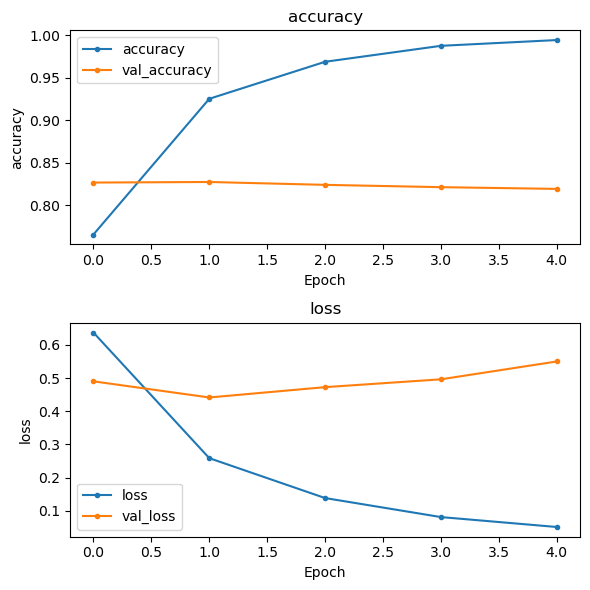


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1721
           1       0.99      1.00      0.99      1732
           2       1.00      1.00      1.00      1725

    accuracy                           1.00      5178
   macro avg       1.00      1.00      1.00      5178
weighted avg       1.00      1.00      1.00      5178



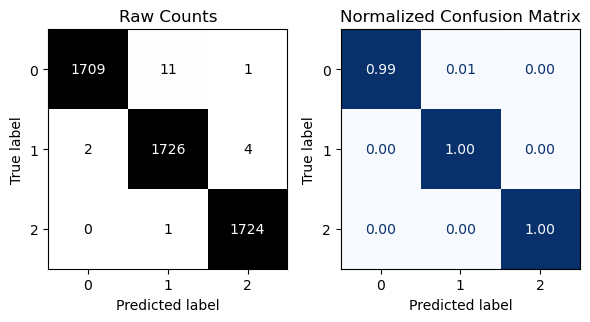


- Evaluating Training Data:
162/162 [==============================] - 1s 4ms/step - loss: 0.0393 - accuracy: 0.9963
{'loss': 0.03927015885710716, 'accuracy': 0.9963306188583374}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       253
           1       0.69      0.82      0.75       254
           2       0.90      0.82      0.86       234

    accuracy                           0.79       741
   macro avg       0.81      0.79      0.80       741
weighted avg       0.80      0.79      0.79       741



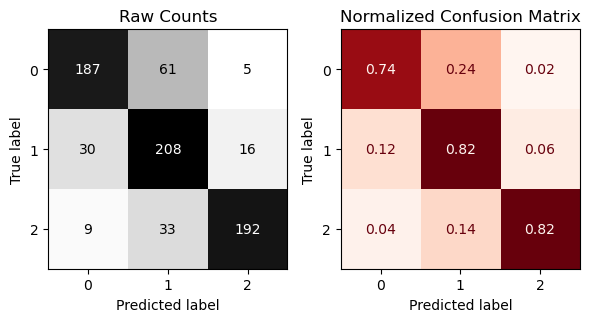


- Evaluating Test Data:
24/24 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.7922
{'loss': 0.6511781811714172, 'accuracy': 0.7921727299690247}


In [26]:
# Build the model with the adapted TextVectorizer
bow_model = build_bow_model(count_vectorizer, name="BoW-Counts")
# How many epochs?
EPOCHS = 30
# Fit the model with callbacks and save history
history = bow_model.fit(
    train_ds,
    epochs=EPOCHS,callbacks=get_callbacks(),
    validation_data=val_ds)
# Evaluate the model with a custom function
fn.evaluate_classification_network(
    bow_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

# Embedding Layer

In [27]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

NameError: name 'sequence_vectorizer' is not defined

In [28]:
SEQUENCE_LENGTH = 400
SEQUENCE_LENGTH

400

In [29]:
# Define output dimension
EMBED_DIM = 100
EMBED_DIM

100

In [30]:
# Defining an embedding layer
embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)

NameError: name 'VOCAB_SIZE' is not defined